In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

In [33]:
test_points = gpd.read_file('/home/anton/dima_experiments/Vip_gZ/data/river_network/results_points/partial/amur/amur_137.0_51.0.gpkg')
test_network = gpd.read_file(
    '/home/anton/dima_experiments/Vip_gZ/data/river_network/geometry/amur/amur_101.gpkg')
    

In [34]:
test_network

,id,rank,acc_range,geometry
0,0.0,small_creeks,100 - 1000,"LINESTRING (135.00292 52.49958, 135.00208 52.4..."
1,1.0,small_creeks,100 - 1000,"LINESTRING (135.02792 52.49958, 135.02875 52.4..."
2,2.0,small_creeks,100 - 1000,"LINESTRING (135.05042 52.49958, 135.05125 52.4..."
3,3.0,small_creeks,100 - 1000,"LINESTRING (135.06708 52.49958, 135.06625 52.4..."
4,4.0,small_creeks,100 - 1000,"LINESTRING (135.10625 52.49958, 135.10708 52.4..."
...,...,...,...,...
31115,3.0,rivers,1000000 - 10000000,"LINESTRING (136.59208 52.43292, 136.59292 52.4..."
31116,4.0,rivers,1000000 - 10000000,"LINESTRING (136.62208 51.20542, 136.62292 51.2..."
31117,5.0,rivers,1000000 - 10000000,"LINESTRING (136.71958 51.23458, 136.72042 51.2..."
31118,6.0,rivers,1000000 - 10000000,"LINESTRING (137.49958 50.03708, 137.49875 50.0..."


In [7]:
from shapely import line_interpolate_point, line_locate_point

In [22]:
gauges = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
test_gauge = gauges.loc[gauges['gauge_id'] == '5024', ['geometry']]
test_gauge

,geometry
765,POINT (137.05142 50.53107)


In [20]:
dist = line_locate_point(test_network['geometry'].values, test_gauge,
                         normalized=False)
test_network['dist'] = dist

In [30]:
gpd.sjoin_nearest(test_gauge, test_network)

/home/anton/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,geometry,index_right,id,rank,acc_range,index
765,POINT (137.05142 50.53107),2017996,21424.0,small_creeks,100 - 1000,None


In [2]:
import sys
sys.path.append('/home/anton/dima_experiments/my_dissertation')
from data_builders.scripts.loaders import multi_var_nc
from visualizations.scripts.drawer import russia_plots, russia_plots_n
from scripts.file_readers import df_reader
from scripts.data_describers import station_describer, mae_percent
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm
import glob
import re

### Recalculate one file

In [3]:
files = glob.glob('../geo_data/meteorology/station_vs_reanalysis/*.csv')

### Stupid debug

In [14]:
## find out which files are cursed
files = glob.glob('../geo_data/meteorology/meteo_ru/*.csv')
def data_reader(csv_path):
    f = pd.read_csv(csv_path, index_col='date')
    f.index = pd.to_datetime(f.index)
    f = f.loc['2008':'2020', :]
    f = f.applymap(
        lambda x: pd.to_numeric(x, errors='coerce'))
    return f


nan_files = {}
empty_files = {}
partial_nans = {}
nan_lens = {}
comp_files = glob.glob('../geo_data/meteorology/station_vs_reanalysis/*.csv')
for f in comp_files:
    s_id = f.split('/')[-1][:-4]
    df = data_reader(f)
    if df.empty:
        empty_files[s_id] = f
    elif df.isna().sum().sum() > 3000:
        nan_files[s_id] = f
    elif df[['prcp']].isna().sum().sum() > 0:
        nan_lens[s_id] = {f'{s_id}': df[['prcp']].isna().sum().sum()}

In [92]:
from scripts.file_readers import (station_lat_lon, read_meteo_station,
                                  xr_for_point)
gdf_file = gpd.read_file('../geo_data/great_db/meteo_stations.gpkg')
gdf_file['gauge_id'] = gdf_file['gauge_id'].astype(str)
gdf_file = gdf_file.set_index('gauge_id')

meteo_lon, meteo_lat = station_lat_lon(gdf_file.loc[f'{station_id}',
                                                    'geometry'])
meteo_dict = {
    'era5_land': multi_var_nc(
        path_to_nc='../geo_data/meteorology/era5-land/russia',
        file_extension='nc'),
    'era5': multi_var_nc(
        path_to_nc='../geo_data/meteorology/era5/russia',
        file_extension='nc'),
    'gpcp': multi_var_nc(
        path_to_nc='../geo_data/meteorology/gpcp_year_new',
        file_extension='nc'),
    'imerg': multi_var_nc(
        path_to_nc='../geo_data/meteorology/imerg_year_new',
        file_extension='nc'),
    'mswep': multi_var_nc(
        path_to_nc='../geo_data/meteorology/mswep_new',
        file_extension='nc')}

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('error')
    described_df_1day = pd.DataFrame()
    for file in tqdm(files, desc='Comparison results...'):
        test_df = df_reader(file)
        station_id = file.split('/')[-1][:-4]
        col_modifier = ['era5_land', 'era5', 'mswep', 'imerg', 'gpcp']
        for col in col_modifier:
            result = station_describer(test_df, frequency='1d', modifier=col,
                                    prcp_station='prcp',
                                    prcp_meteo=f'{col}_prcp')
            for key, val in result.items():
                described_df_1day.loc[station_id, key] = val

### Get daily RMSE, daily absolute and correlation coefficient for station

### Plot results

In [4]:
station_geometry = gpd.read_file('../geo_data/great_db/meteo_stations.gpkg')
station_geometry['gauge_id'] = station_geometry['gauge_id'].astype(str)
station_geometry = station_geometry.set_index('gauge_id')

basemap_data = gpd.read_file(
    '../geo_data/great_db/geometry/basemap_2023.gpkg')
basin_districts = gpd.read_file(
    '../geo_data/great_db/geometry/basin_districts.gpkg')
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 26, 10,
                                           11, 12, 27, 14, 15, 16, 17, 18, 19,
                                           20, 21, 22, 23, 24, 25, 9, 13])
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={'BAS_OKRUG': 'name1'})

In [5]:
def metric_description(station_geom: gpd.GeoDataFrame(),
                       basemap: gpd.GeoDataFrame(),
                       basin_districts: gpd.GeoDataFrame(),
                       res_df: pd.DataFrame(),
                       metric_column: str):

    res_df = res_df.loc[:, [
        c for c in res_df.columns if f'{metric_column}' in c]]
    metric_cols = res_df.columns
    geom_example = station_geom.join(res_df)

    points_in_russia = gpd.sjoin(
        geom_example[['geometry']].set_crs(epsg=4326, allow_override=True),
        basemap[['geometry']].set_crs(epsg=4326, allow_override=True)).index

    geom_example = geom_example.loc[points_in_russia, :]

    # give ugms some shine
    for i, geom in enumerate(basin_districts['geometry']):

        ugms_part = geom_example.loc[[geom.intersects(gage_point)
                                      for gage_point
                                      in geom_example['geometry']], :]

        basin_districts.loc[i,
                            metric_cols] = ugms_part[metric_cols].median()

    return (geom_example, basin_districts, metric_cols)

### Precipitation

#### One day

In [6]:
def res_describer(freq: str):
    described_df = pd.DataFrame()
    for file in tqdm(files, desc=f'Comparison results for {freq} span'):
        test_df = df_reader(file)
        station_id = file.split('/')[-1][:-4]
        col_modifier = ['era5_land', 'era5', 'mswep', 'gpcp']
        for col in col_modifier:
            result = station_describer(test_df, frequency=f'{freq}', modifier=col,
                                       prcp_station='prcp',
                                       prcp_meteo=f'{col}_prcp')
            for key, val in result.items():
                described_df.loc[station_id, key] = val

    (pearson_day_point,
     pearson_1day_bas, pearson_1day_cols) = metric_description(
         station_geom=station_geometry,
         basemap=basemap_data,
         basin_districts=basin_districts,
         res_df=described_df,
         metric_column='pearson')
    (mean_day_point,
     mean_1day_bas, mean_1day_cols) = metric_description(
         station_geom=station_geometry,
         basemap=basemap_data,
         basin_districts=basin_districts,
         res_df=described_df,
         metric_column='mean')

    res_df_cols = [(i.split("_")[0], int(re.match(r'[\d]+', f'{freq}')[0]))
                   if len(i.split("_")) == 2
                   else ("_".join(i.split("_")[:2]), int(re.match(r'[\d]+', f'{freq}')[0]))
                   for i in pearson_1day_cols]

    mean_df = mean_day_point[mean_1day_cols]
    mean_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    mean_df = mean_df.mean().to_frame().T
    mean_df.index = ['∆, мм']

    pearson_df = pearson_day_point[pearson_1day_cols]
    pearson_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    pearson_df = pearson_df.mean().to_frame().T
    pearson_df.index = ['r']

    return {'mean_df': mean_df,
            'pearson_df': pearson_df}

In [7]:
freq = '1d'
described_df = pd.DataFrame()
for file in tqdm(files, desc=f'Comparison results for {freq} span'):
    test_df = df_reader(file)
    station_id = file.split('/')[-1][:-4]
    col_modifier = ['era5_land', 'era5', 'mswep', 'gpcp']
    for col in col_modifier:
        result = station_describer(test_df, frequency=f'{freq}', modifier=col,
                                    prcp_station='prcp',
                                    prcp_meteo=f'{col}_prcp')
        for key, val in result.items():
            described_df.loc[station_id, key] = val

(pearson_day_point,
    pearson_1day_bas, pearson_1day_cols) = metric_description(
        station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df,
    metric_column='pearson')

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [8]:
pearson_1day_bas

,name1,geometry,era5_land_pearson,era5_pearson,mswep_pearson,gpcp_pearson
0,лнр,"MULTIPOLYGON (((36.22324 46.56331, 36.22304 46...",NaN,NaN,NaN,NaN
1,днр,"MULTIPOLYGON (((32.55747 46.06686, 32.55777 46...",0.652121,0.634031,0.772011,0.546475
2,херсон,"MULTIPOLYGON (((37.87218 49.23760, 37.87269 49...",0.696497,0.666838,0.680231,0.512294
3,сон,"MULTIPOLYGON (((38.33152 50.07360, 38.33233 50...",NaN,NaN,NaN,NaN
4,Двинско-Печорский,"MULTIPOLYGON (((38.85546 59.40897, 38.85640 59...",0.713687,0.644552,0.755646,0.330201
5,Балтийский,"MULTIPOLYGON (((30.90941 55.00907, 30.90016 55...",0.742231,0.711452,0.874516,0.479949
6,Ангаро-Байкальский,"MULTIPOLYGON (((111.15035 50.81063, 111.14815 ...",0.607025,0.514834,0.624445,0.370540
7,Баренцево-Беломорский,"MULTIPOLYGON (((36.50054 63.25648, 36.50115 63...",0.783201,0.747675,0.857933,0.512824
8,Амурский,"MULTIPOLYGON (((142.75728 46.63792, 142.76484 ...",0.603410,0.499055,0.550278,0.357910
9,Ленский. обрез,"MULTIPOLYGON (((117.66208 54.63161, 117.66208 ...",0.679309,0.591177,0.684691,0.369562


In [30]:
fullfillment = list()
for s_id in pearson_day_point.index:
    file = pd.read_csv(f'../geo_data/meteorology/station_vs_reanalysis/{s_id}.csv')
    file = file[['t_min', 't_max', 'prcp']]
    fullfillment.append((file[['t_min', 't_max', 'prcp']].isna().sum(
    ) / len(file[['t_min', 't_max', 'prcp']]) * 100).mean())

In [37]:
file = pd.read_csv(f'../geo_data/meteorology/station_vs_reanalysis/{s_id}.csv')

In [39]:
(file['era5_land_prcp'] - file['prcp']).mean()

-1.3580439756107503

In [40]:
file['era5_land_prcp'].mean() - file['prcp'].mean()

-1.3580439756107503

In [10]:
one_day_prcp = res_describer(freq='1d')

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [11]:
one_day_prcp

{'mean_df':       era5_land      era5     mswep      gpcp
               1         1         1         1
 ∆, мм -0.713345 -0.251991 -0.051144 -0.260394,
 'pearson_df':   era5_land      era5     mswep      gpcp
           1         1         1         1
 r  0.652816  0.573679  0.683649  0.345421}

In [ ]:
one_day_prcp = res_describer(freq='1d')

ten_day_prcp = res_describer(freq='10d')

one_month_prcp = res_describer(freq='30d')

In [8]:
mean_df = pd.concat([one_day_prcp['mean_df'], ten_day_prcp['mean_df'],
                     one_month_prcp['mean_df']], axis=1)
mean_df.columns = pd.MultiIndex.from_tuples(mean_df.columns,
                                            names=['Датасет',
                                                   'Интервал, дней'],
                                            sortorder=None)
mean_df.sort_index(inplace=True, axis=1,
                   level=['Датасет', 'Интервал, дней'], ascending=True)

pearson_df = pd.concat([one_day_prcp['pearson_df'], ten_day_prcp['pearson_df'],
                        one_month_prcp['pearson_df']], axis=1)
pearson_df.columns = pd.MultiIndex.from_tuples(pearson_df.columns,
                                               names=['Датасет',
                                                      'Интервал, дней'],
                                               sortorder=None)
pearson_df.sort_index(inplace=True, axis=1,
                      level=['Датасет', 'Интервал, дней'], ascending=True)

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
res_df = pd.concat([mean_df, pearson_df])

In [11]:
res_df.to_csv('./precipitation_table.csv')

In [9]:
freq = '1d'
described_df_1day = pd.DataFrame()
for file in tqdm(files, desc=f'Comparison results for {freq} span'):
    test_df = df_reader(file)
    station_id = file.split('/')[-1][:-4]
    col_modifier = ['era5_land', 'era5', 'mswep', 'gpcp']
    for col in col_modifier:
        result = station_describer(test_df, frequency=f'{freq}', modifier=col,
                                   prcp_station='prcp',
                                   prcp_meteo=f'{col}_prcp')
        for key, val in result.items():
            described_df_1day.loc[station_id, key] = val

pearson_1day_point, pearson_1day_bas, pearson_1day_cols = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df_1day,
    metric_column='pearson')
mean_1day_point, mean_1day_bas, mean_1day_cols = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df_1day,
    metric_column='mean')

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [15]:
mean_1day_bas = mean_1day_bas.set_index('name1')


KeyError: "None of ['name1'] are in the columns"

In [17]:
mean_1day_bas[mean_1day_bas.iloc[:, -4:] > 0].dropna(how='all')

,geometry,era5_land_pearson,era5_pearson,mswep_pearson,gpcp_pearson,era5_land_mean,era5_mean,mswep_mean,gpcp_mean
name1,,,,,,,,,
херсон,None,NaN,NaN,NaN,NaN,NaN,0.093906,0.190119,NaN
Балтийский,None,NaN,NaN,NaN,NaN,NaN,NaN,0.001286,NaN
Баренцево-Беломорский,None,NaN,NaN,NaN,NaN,NaN,NaN,0.013922,NaN
Кубанский,None,NaN,NaN,NaN,NaN,NaN,0.449457,0.235944,0.139616
Калининград,None,NaN,NaN,NaN,NaN,NaN,0.044173,0.045848,NaN
Крымский,None,NaN,NaN,NaN,NaN,NaN,NaN,0.058298,NaN


In [22]:
mean_1day_bas['mswep_mean'].sort_values(ascending=False)

name1
Кубанский                0.235944
херсон                   0.190119
Крымский                 0.058298
Калининград              0.045848
Баренцево-Беломорский    0.013922
Балтийский               0.001286
Донской                 -0.000158
Верхневолжский          -0.008619
Днепровский             -0.012679
Камский                 -0.019953
Двинско-Печорский       -0.020946
Нижневолжский           -0.022495
Окский                  -0.022999
Иртышский               -0.026337
Енисейский. обрез       -0.032968
Верхнеобский            -0.036135
Нижнеобский             -0.041736
Амурский                -0.070747
днр                     -0.071860
Западно-Каспийский      -0.071949
Енисейский              -0.088485
Ленский                 -0.091257
Уральский               -0.094469
Анадыро-Колымский       -0.096384
Ленский. обрез          -0.100403
Ангаро-Байкальский      -0.117739
лнр                           NaN
сон                           NaN
Name: mswep_mean, dtype: float64

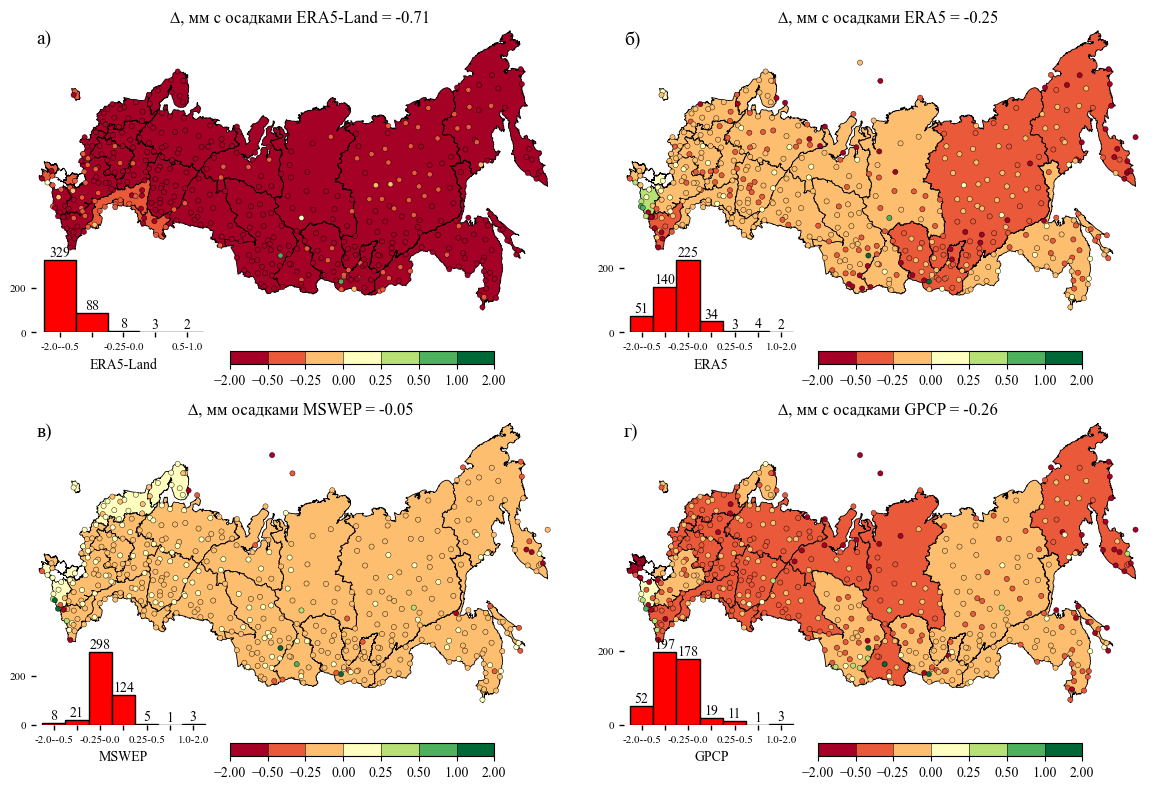

In [13]:
metric_name = '∆, мм'
res_dict = mean_1day_point[mean_1day_cols].mean().to_dict()
e5l_mean, e5_mean, mswp_mean, gpcp_mean = res_dict.values()


meteo_nse = russia_plots_n(gdf_to_plot=mean_1day_point,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=2,
                           list_of_limits=[-2, -0.5, -0.25, 0.0, 0.25, 0.5, 1, 2],
                           label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
                           columns_from_gdf=mean_1day_cols,
                           with_histogram=True,
                           title_text=[f'{metric_name} с осадками ERA5-Land = {e5l_mean:.2f}',
                                       f'{metric_name} с осадками ERA5 = {e5_mean:.2f}',
                                       f'{metric_name} осадками MSWEP = {mswp_mean:.2f}',
                                       f'{metric_name} с осадками GPCP = {gpcp_mean:.2f}'],
                           hist_name=['ERA5-Land', 'ERA5', 'MSWEP', 'GPCP'],
                           ugms=True, ugms_gdf=mean_1day_bas)
meteo_nse.savefig('./images/precipitation_daily_diff.png',
                  dpi=600, bbox_inches='tight')

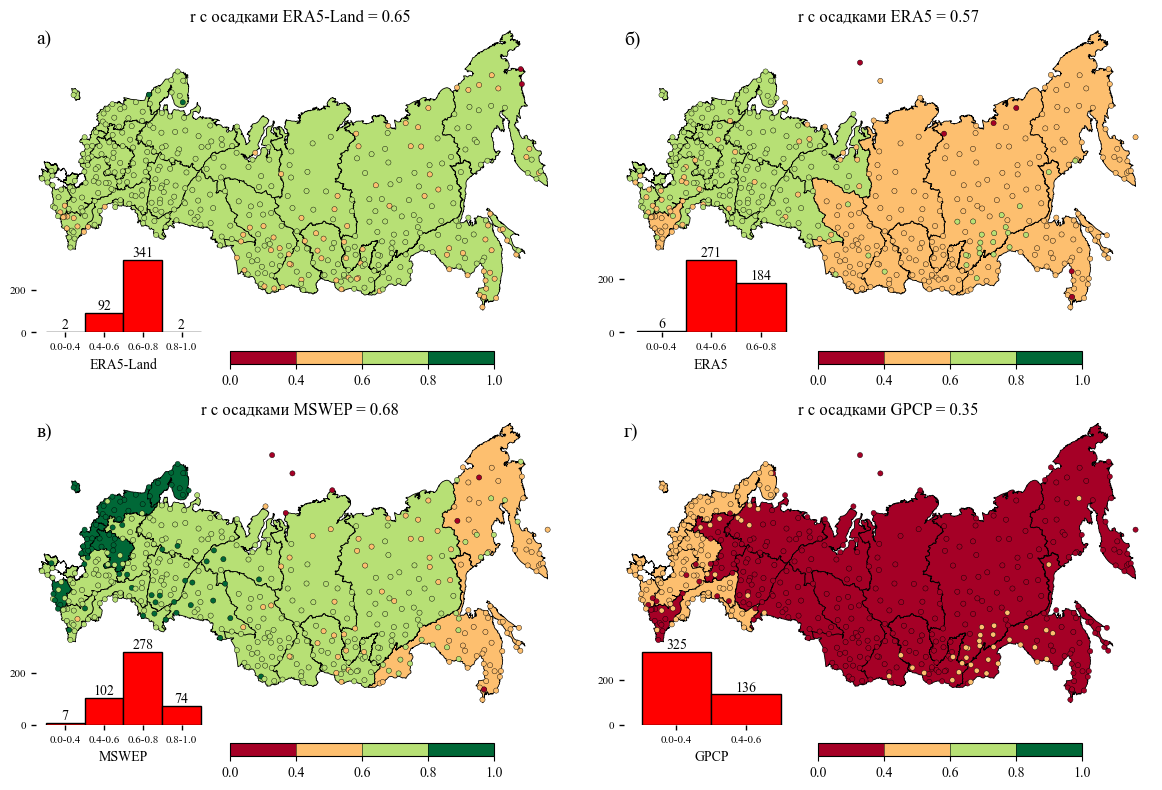

In [14]:
metric_name = 'r'
res_dict = pearson_1day_point[pearson_1day_cols].mean().to_dict()
e5l_mean, e5_mean, mswp_mean, gpcp_mean = res_dict.values()


meteo_nse = russia_plots_n(gdf_to_plot=pearson_1day_point,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=2,
                           list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
                           label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
                           columns_from_gdf=pearson_1day_cols,
                           with_histogram=True,
                           title_text=[f'{metric_name} с осадками ERA5-Land = {e5l_mean:.2f}',
                                       f'{metric_name} с осадками ERA5 = {e5_mean:.2f}',
                                       f'{metric_name} с осадками MSWEP = {mswp_mean:.2f}',
                                       f'{metric_name} с осадками GPCP = {gpcp_mean:.2f}'],
                           hist_name=['ERA5-Land', 'ERA5', 'MSWEP', 'GPCP'],
                           ugms=True, ugms_gdf=pearson_1day_bas)
meteo_nse.savefig('./images/precipitation_daily_r.png',
                  dpi=600, bbox_inches='tight')

### Temperature

In [88]:
df_t2m_max = pd.DataFrame()
for file in tqdm(files, desc=f'Comparison results for {freq} span'):
    test_df = df_reader(file)
    station_id = file.split('/')[-1][:-4]
    col_modifier = ['era5_land', 'era5']
    for col in col_modifier:
        result = station_describer(test_df, frequency=f'{freq}', modifier=col,
                                   prcp_station='t_max',
                                   prcp_meteo=f'{col}_2m_max')
        for key, val in result.items():
            df_t2m_max.loc[station_id, key] = val

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [16]:
def res_describer(freq: str, col_modifier: list, mean_symbol: str,
                  station_code: str, era_code: str,
                  with_temp: str = ''):
    described_df = pd.DataFrame()
    for file in tqdm(files, desc=f'Comparison results for {freq} span'):
        test_df = df_reader(file)
        station_id = file.split('/')[-1][:-4]
        # col_modifier = ['era5_land', 'era5', 'mswep', 'gpcp']
        for col in col_modifier:
            result = station_describer(test_df, frequency=f'{freq}', modifier=col,
                                       prcp_station=f'{station_code}',
                                       prcp_meteo=f'{col}_{era_code}')
            for key, val in result.items():
                described_df.loc[station_id, key] = val

    (pearson_day_point,
     pearson_1day_bas, pearson_1day_cols) = metric_description(
         station_geom=station_geometry,
         basemap=basemap_data,
         basin_districts=basin_districts,
         res_df=described_df,
         metric_column='pearson')
    (mean_day_point,
     mean_1day_bas, mean_1day_cols) = metric_description(
         station_geom=station_geometry,
         basemap=basemap_data,
         basin_districts=basin_districts,
         res_df=described_df,
         metric_column='mean')
    if with_temp:
        res_df_cols = [(f'{i.split("_")[0]} {with_temp}',
                        int(re.match(r'[\d]+', f'{freq}')[0]))
                       if len(i.split("_")) == 2
                       else (f'{"_".join(i.split("_")[:2])} {with_temp}',
                             int(re.match(r'[\d]+', f'{freq}')[0]))
                       for i in pearson_1day_cols]
    else:
        res_df_cols = [(i.split("_")[0],
                        int(re.match(r'[\d]+', f'{freq}')[0]))
                       if len(i.split("_")) == 2
                       else ("_".join(i.split("_")[:2]),
                             int(re.match(r'[\d]+', f'{freq}')[0]))
                       for i in pearson_1day_cols]

    mean_df = mean_day_point[mean_1day_cols]
    mean_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    mean_df = mean_df.mean().to_frame().T
    mean_df.index = [f'∆, {mean_symbol}']

    pearson_df = pearson_day_point[pearson_1day_cols]
    pearson_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    pearson_df = pearson_df.mean().to_frame().T
    pearson_df.index = ['r']

    return {'mean_df': mean_df,
            'pearson_df': pearson_df}

In [19]:
one_day_t_max = res_describer(freq='1d', col_modifier=['era5_land', 'era5'],
                              station_code='t_max', era_code='2m_max',
                              with_temp='t макс.', mean_symbol='°')
ten_day_t_max = res_describer(freq='10d', col_modifier=['era5_land', 'era5'],
                              station_code='t_max', era_code='2m_max',
                              with_temp='t макс.', mean_symbol='°')
one_day_t_min = res_describer(freq='1d', col_modifier=['era5_land', 'era5'],
                              station_code='t_min', era_code='2m_min',
                              with_temp='t мин.', mean_symbol='°')
ten_day_t_min = res_describer(freq='10d', col_modifier=['era5_land', 'era5'],
                              station_code='t_min', era_code='2m_min',
                              with_temp='t мин.', mean_symbol='°')

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

Comparison results for 10d span:   0%|          | 0/588 [00:00<?, ?it/s]

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

Comparison results for 10d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [20]:
mean_df = pd.concat([one_day_t_max['mean_df'], one_day_t_min['mean_df'],
                     ten_day_t_max['mean_df'], ten_day_t_min['mean_df']],
                    axis=1)
mean_df.columns = pd.MultiIndex.from_tuples(mean_df.columns,
                                            names=['Датасет',
                                                   'Интервал, дней'],
                                            sortorder=None)
mean_df.sort_index(inplace=True, axis=1,
                   level=['Датасет', 'Интервал, дней'], ascending=True)
pearson_df = pd.concat(
    [one_day_t_max['pearson_df'], one_day_t_min['pearson_df'],
        ten_day_t_max['pearson_df'], ten_day_t_min['pearson_df']],
    axis=1)
pearson_df.columns = pd.MultiIndex.from_tuples(pearson_df.columns,
                                               names=['Датасет',
                                                      'Интервал, дней'],
                                               sortorder=None)
pearson_df.sort_index(inplace=True, axis=1,
                      level=['Датасет', 'Интервал, дней'], ascending=True)

pd.options.display.float_format = '{:,.2f}'.format
res_df = pd.concat([mean_df, pearson_df])
res_df

Датасет        era5 t макс.       era5 t мин.       era5_land t макс.        \
Интервал, дней           1     10          1     10                1     10   
∆, °                   1.09 10.88       -0.24 -2.37              1.46 14.63   
r                      0.99  1.00        0.97  1.00              0.99  1.00   

Датасет        era5_land t мин.        
Интервал, дней               1     10  
∆, °                      -0.88 -8.75  
r                          0.97  0.99

In [21]:
res_df.to_csv('./temperature_table.csv')

In [2]:
import glob
len(glob.glob('../geo_data/meteorology/station_vs_reanalysis/*.csv'))

588

### Read meteo station geometry

In [5]:
gdf_file = gpd.read_file('../geo_data/great_db/meteo_stations.gpkg')
gdf_file['gauge_id'] = gdf_file['gauge_id'].astype(str)
gdf_file = gdf_file.set_index('gauge_id')

In [6]:
def station_lat_lon(geom_row):
    lon, lat = geom_row.xy
    lon, lat = lon[0], lat[0]

    return lon, lat


def read_meteo_station(csv_path):
    test_meteo = pd.read_csv(csv_path, index_col='date')
    test_meteo.index = pd.to_datetime(test_meteo.index)
    test_meteo = test_meteo.loc[:'2020', :]
    test_meteo = test_meteo.applymap(
        lambda x: pd.to_numeric(x, errors='coerce'))

    return test_meteo


def xr_for_point(xr_file, meteo_col, meteo_lat, meteo_lon):
    xr_file = xr_file.to_array().squeeze()
    xr_lons = xr_file['lon'].values
    xr_lats = xr_file['lat'].values
    lons_id = np.argmin(np.abs((xr_lons - meteo_lon)))
    lats_id = np.argmin(np.abs((xr_lats - meteo_lat)))
    # write down to dataframe
    xr_df = pd.DataFrame()
    xr_df[f'{meteo_col}'] = xr_file[:, lats_id, lons_id]
    xr_df['date'] = xr_file.time
    xr_df = xr_df.set_index('date')
    xr_df = xr_df.loc['2008':'2020', :]

    return xr_df

In [7]:
meteo_dict = {
    'era5_land': multi_var_nc(
        path_to_nc='../geo_data/meteorology/era5-land/russia',
        file_extension='nc'),
    'era5': multi_var_nc(
        path_to_nc='../geo_data/meteorology/era5/russia',
        file_extension='nc'),
    'gpcp': multi_var_nc(
        path_to_nc='../geo_data/meteorology/gpcp_year_new',
        file_extension='nc'),
    'imerg': multi_var_nc(
        path_to_nc='../geo_data/meteorology/imerg_year_new',
        file_extension='nc'),
    'mswep': multi_var_nc(
        path_to_nc='../geo_data/meteorology/mswep_new',
        file_extension='nc')}

### For each station extend data from reanalysis

In [ ]:
for file in tqdm(glob.glob('../geo_data/meteorology/meteo_ru/*.csv'),
                 desc=f'Calculation for Meteo Stations'):
    station_id = file.split('/')[-1][:-4]
    # read df for meteo station
    meteo_station = read_meteo_station(file)

    meteo_lon, meteo_lat = station_lat_lon(gdf_file.loc[f'{station_id}',
                                                        'geometry'])
    
    for ds, data_desc in meteo_dict.items():
        for var, pathes in data_desc.items():
            if 'precipitation' in var:
                col_var = f'{ds}_prcp'
                xr_file = xr.open_mfdataset(pathes)
                if 'longitude' in xr_file.dims:
                    xr_file = xr_file.rename(
                        {'longitude': 'lon',
                         'latitude': 'lat'})                
                xr_df = xr_for_point(xr_file, col_var, meteo_lat, meteo_lon)
                meteo_station = pd.concat([meteo_station, xr_df], axis=1)
            else:
                col_var = 't2m'
                col_var = var.split('_')
                col_var[1] = ds
                col_var[1], col_var[0], col_var[2] = col_var[0], col_var[1], col_var[2]
                col_var = '_'.join(col_var)
                
                xr_file = xr.open_mfdataset(pathes)
                if 'longitude' in xr_file.dims:
                    xr_file = xr_file.rename(
                        {'longitude': 'lon',
                         'latitude': 'lat'})
                xr_df = xr_for_point(xr_file, col_var, meteo_lat, meteo_lon)
                meteo_station = pd.concat([meteo_station, xr_df], axis=1)
    meteo_station = meteo_station.loc['2008':'2020', :]
    meteo_station.to_csv(
        f'../geo_data/meteorology/station_vs_reanalysis/{station_id}.csv',
        index=False)